Adopted from

article
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

and code    
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

# Setup

In [1]:
!pip install pandas --upgrade --user
!pip install keras --upgrade --user
!pip install seaborn --upgrade --user
!pip install boto3 --upgrade --user

Requirement already up-to-date: pandas in ./.local/lib/python3.6/site-packages (1.0.2)
Requirement already up-to-date: keras in ./.local/lib/python3.6/site-packages (2.3.1)
Requirement already up-to-date: seaborn in ./.local/lib/python3.6/site-packages (0.10.0)
Requirement already up-to-date: boto3 in ./.local/lib/python3.6/site-packages (1.12.22)


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from keras import backend as K
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import boto3
import os

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


# Read data

In [3]:
os.environ['AWS_ACCESS_KEY_ID'] = <AWS-KEY>
os.environ['AWS_SECRET_ACCESS_KEY'] = <AWS-SECRET>
os.environ['AWS_REGION'] = 'eu-west-1'
os.environ['S3_REGION'] = 'eu-west-1'
os.environ['S3_ENDPOINT'] = 's3.eu-west-1.amazonaws.com'
os.environ['S3_USE_HTTPS'] = '1' 
os.environ['S3_VERIFY_SSL'] = '1'

client = boto3.client('s3')
obj = client.get_object(Bucket='fdp-killrweather-data', Key='kubeflow/fraud_detection/data/creditcard.csv')
df = pd.read_csv(obj['Body'])

# Exploration of Data

In [4]:
print(df.shape)
df.isnull().values.any()

(284807, 31)


False

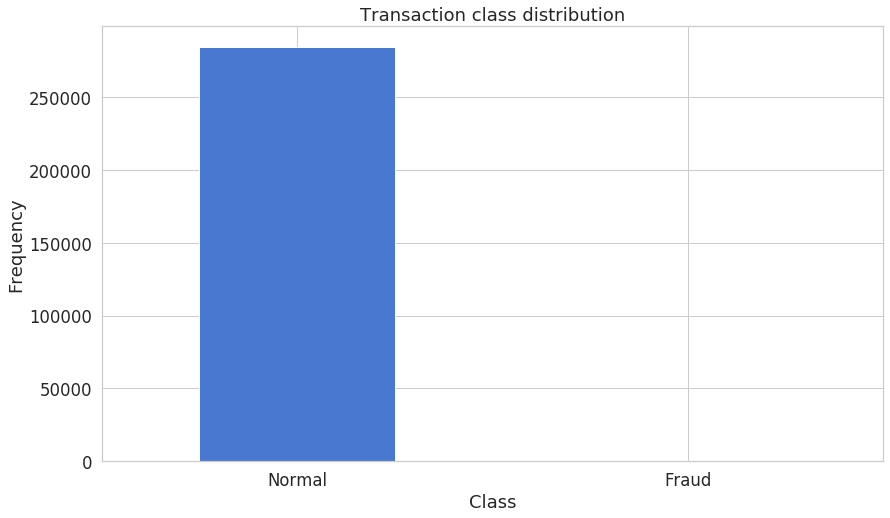

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [6]:
fraud = df[df.Class == 1]
normal = df[df.Class == 0]
print(fraud.shape)
print(normal.shape)

(492, 31)
(284315, 31)


In [7]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [8]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

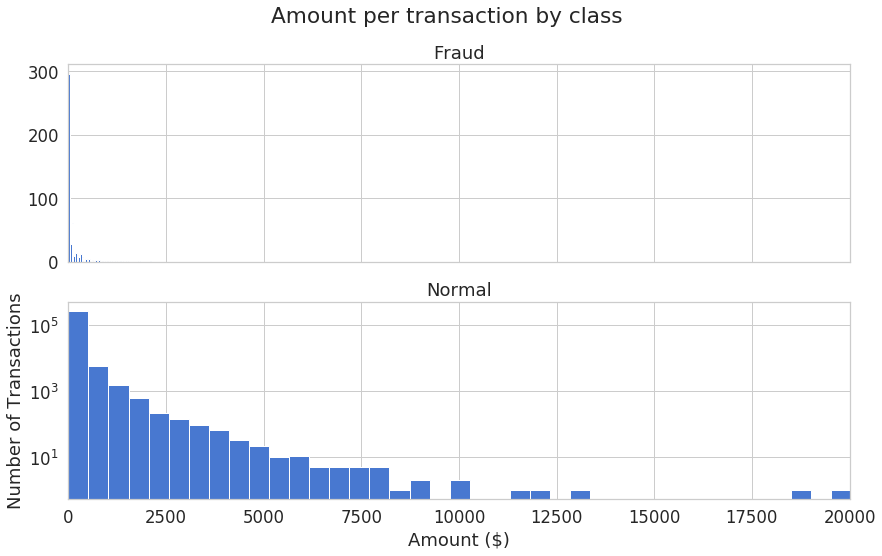

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

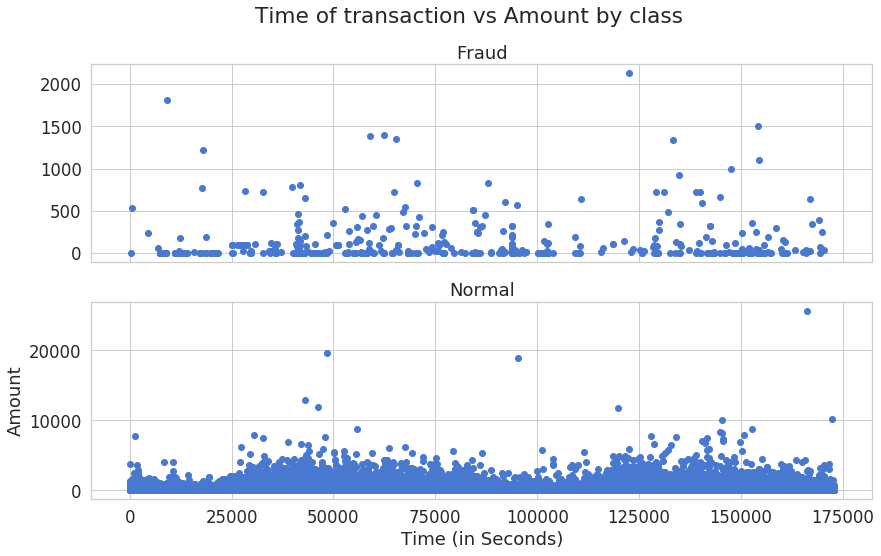

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Preparing the data

In [11]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
# Note here that we are training our model on the normal transactions, only, which means
# that the resulting model represent normal, not fraugulent transactions 
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape)

(227451, 29)


# Building the model

In [12]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
# create TF session and set it in Keras
sess = tf.Session()
K.set_session(sess)
K.set_learning_phase(1)

In [14]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history


Train on 227451 samples, validate on 56962 samples


Epoch 1/100
227451/227451 [==============================] - 20s 87us/step - loss: 0.8329 - accuracy: 0.5457 - val_loss: 0.7972 - val_accuracy: 0.6109

Epoch 2/100
227451/227451 [==============================] - 19s 85us/step - loss: 0.7593 - accuracy: 0.6208 - val_loss: 0.7823 - val_accuracy: 0.6286
Epoch 3/100
227451/227451 [==============================] - 19s 83us/step - loss: 0.7504 - accuracy: 0.6343 - val_loss: 0.7779 - val_accuracy: 0.6382
Epoch 4/100
227451/227451 [==============================] - 18s 81us/step - loss: 0.7462 - accuracy: 0.6399 - val_loss: 0.7738 - val_accuracy: 0.6445
Epoch 5/100
227451/227451 [==============================] - 19s 82us/step - loss: 0.7445 - accuracy: 0.6407 - val_loss: 0.7733 - val_accuracy: 0.6431
Epoch 6/100
227451/227451 [==============================] - 18s 81us/step - loss: 0.7428 - accuracy: 0.6418 - val_loss: 0.7718 - val_accuracy: 0.6477
Epoch 7/100
227451/227451 [============

In [15]:
autoencoder = load_model('model.h5')

# Evaluation

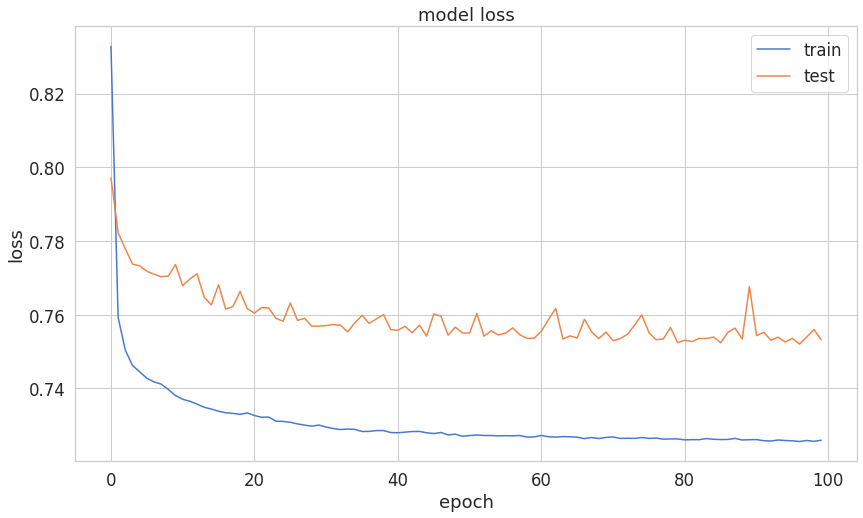

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

prediction data

In [17]:
print(X_test.shape)
print(X_test[:10])

predictions = autoencoder.predict(X_test)

(56962, 29)
[[-1.65265066e+01  8.58497180e+00 -1.86498532e+01  9.50559352e+00
  -1.37938185e+01 -2.83240430e+00 -1.67016943e+01  7.51734390e+00
  -8.50705864e+00 -1.41101844e+01  5.29923635e+00 -1.08340065e+01
   1.67112025e+00 -9.37385858e+00  3.60805642e-01 -9.89924654e+00
  -1.92362924e+01 -8.39855199e+00  3.10173537e+00 -1.51492344e+00
   1.19073869e+00 -1.12767001e+00 -2.35857877e+00  6.73461329e-01
  -1.41369967e+00 -4.62762361e-01 -2.01857525e+00 -1.04280417e+00
   1.10283362e+00]
 [ 3.39812064e-01 -2.74374524e+00 -1.34069511e-01 -1.38572931e+00
  -1.45141332e+00  1.01588659e+00 -5.24379057e-01  2.24060376e-01
   8.99746005e-01 -5.65011684e-01 -8.76702573e-02  9.79426988e-01
   7.68828168e-02 -2.17883812e-01 -1.36829588e-01 -2.14289209e+00
   1.26956065e-01  1.75266151e+00  4.32546224e-01  5.06043885e-01
  -2.13435844e-01 -9.42525025e-01 -5.26819175e-01 -1.15699190e+00
   3.11210510e-01 -7.46646679e-01  4.09958027e-02  1.02037825e-01
   1.72625520e+00]
 [ 1.39959027e+00 -5.90701

In [34]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df[:10])

        reconstruction_error  true_class
43428              77.668931           1
49906               0.808332           0
29474               0.273051           0
276481              0.422423           0
278846              0.182548           0
101565              1.033464           0
260880              0.197029           0
214337              0.424386           0
201575              0.596749           0
81055               2.813502           0


In [35]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.743569,0.001720
std,3.324556,0.041443
min,0.051760,0.000000
25%,0.252251,0.000000
50%,0.400734,0.000000
75%,0.633487,0.000000
max,252.169771,1.000000


# Reconstruction error without fraud

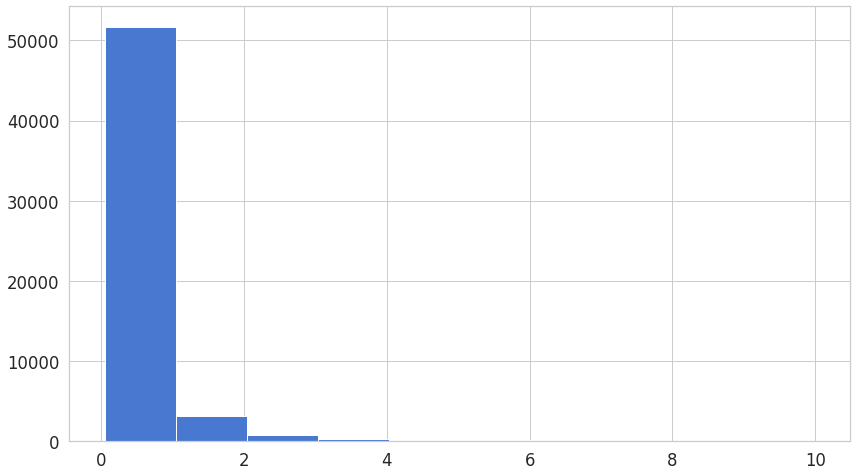

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [39]:
normal_error_df.describe()

,reconstruction_error,true_class
count,56597.000000,56597.0
mean,0.578232,0.0
std,0.761910,0.0
min,0.051760,0.0
25%,0.251577,0.0
50%,0.398440,0.0
75%,0.626760,0.0
max,9.994361,0.0


# Reconstruction error with fraud

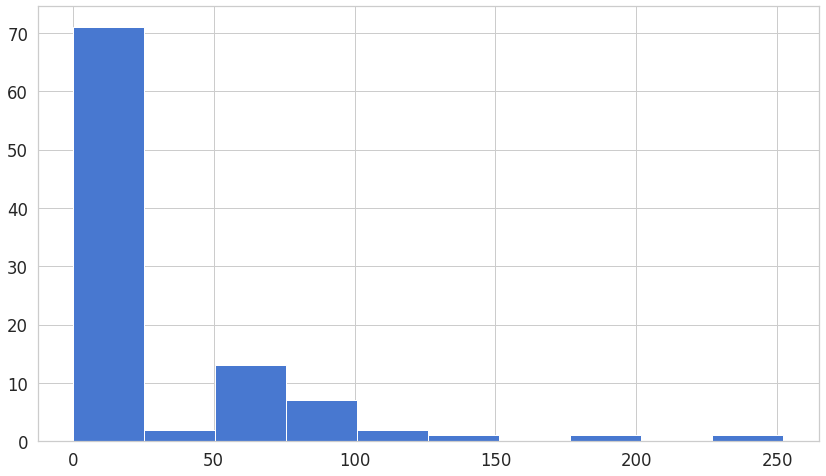

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [41]:
fraud_error_df.describe()

,reconstruction_error,true_class
count,98.000000,98.0
mean,29.553863,1.0
std,43.989745,0.0
min,0.152702,1.0
25%,4.045020,1.0
50%,9.931970,1.0
75%,49.071414,1.0
max,252.169771,1.0


In [21]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

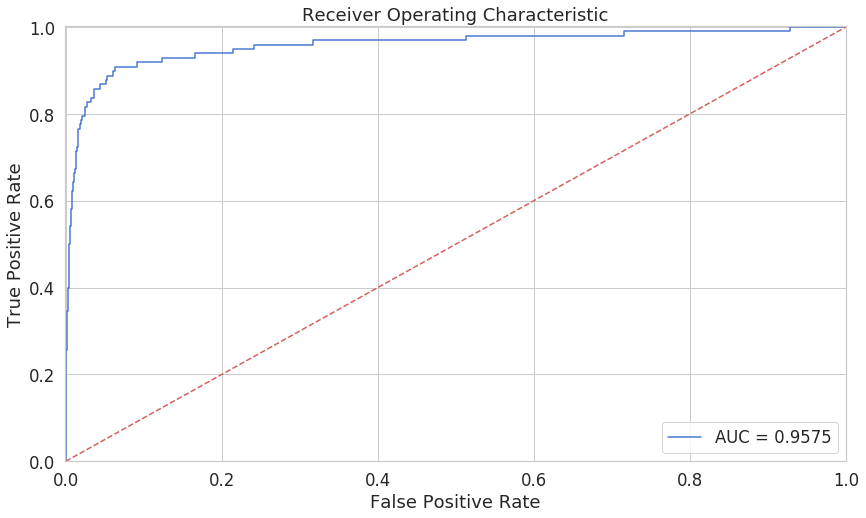

In [22]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# Precision vs Recall

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$


High precision relates to a low false positive rate, and high recall relates to a low false negative rate.High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

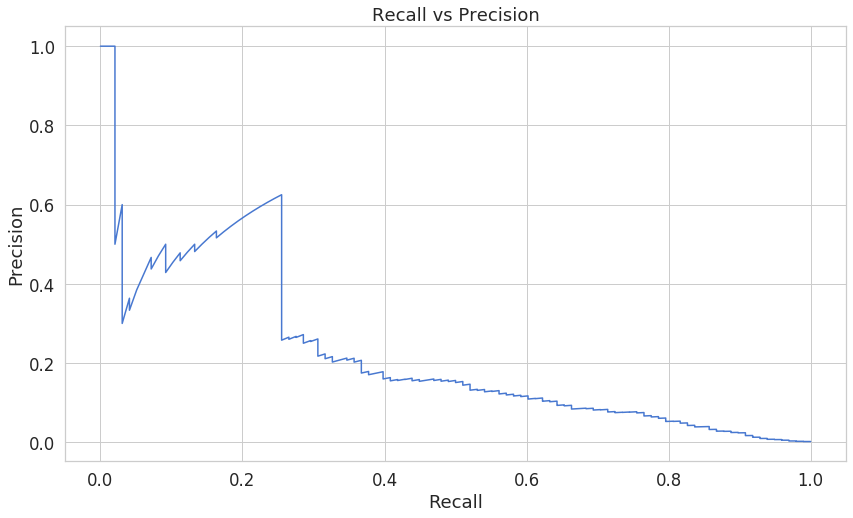

In [29]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

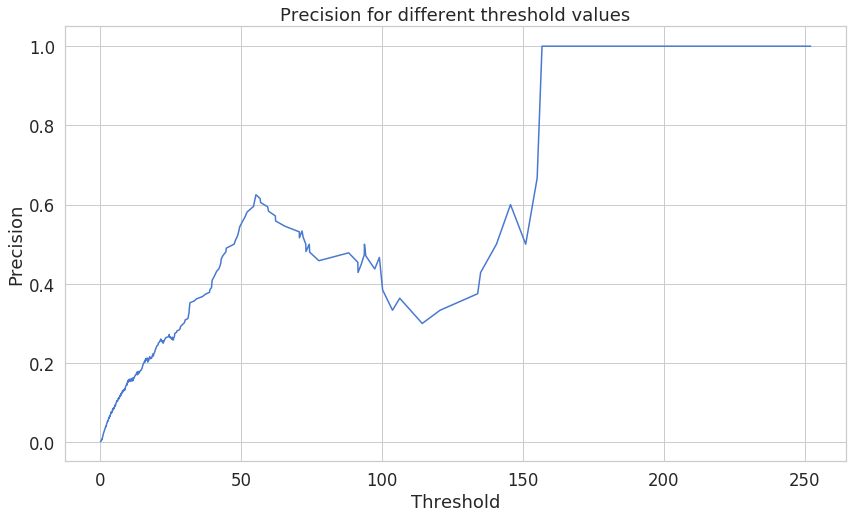

In [30]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

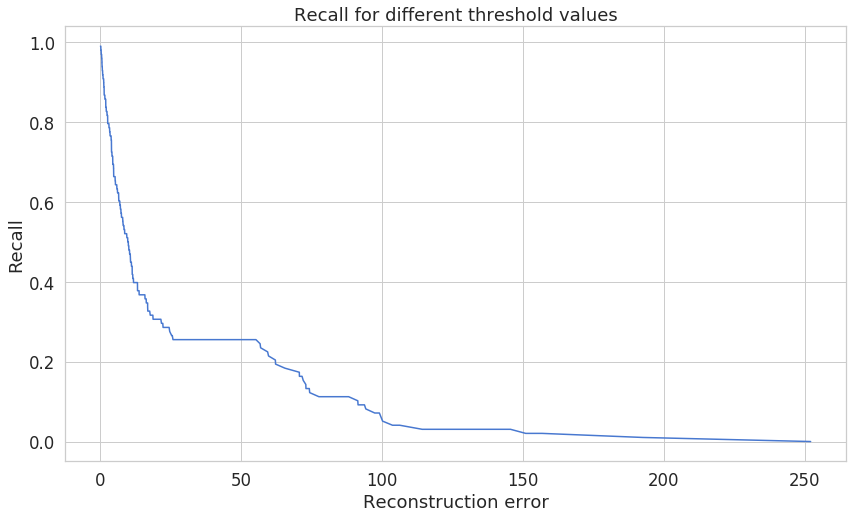

In [31]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

# Prediction

Our model doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [23]:
threshold = 2.9

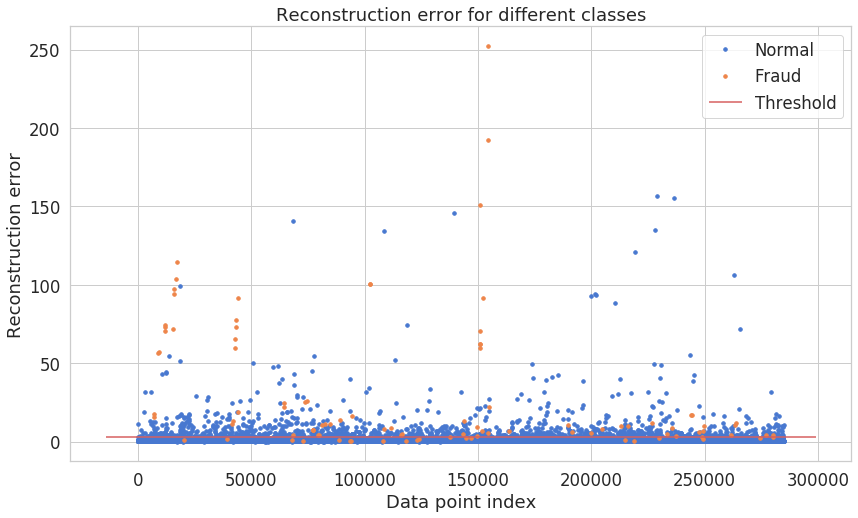

In [24]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Confusion Matrix

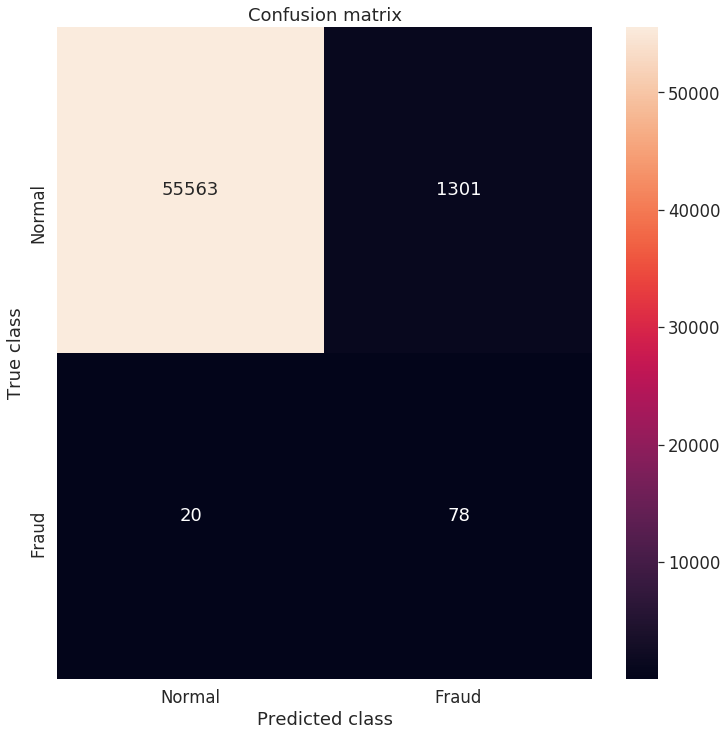

In [25]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Describe the model

In [26]:
autoencoder.summary()
print('input :', autoencoder.input)
print('output :', autoencoder.output)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________
input : Tensor("input_1_1:0", shape=(?, 29), dtype=float32)
output : Tensor("dense_4_1/Relu:0", shape=(?, 29), dtype=float32)


# Export model

In [27]:
# inputs/outputs
tensor_info_input = tf.saved_model.utils.build_tensor_info(autoencoder.input)
tensor_info_pred = tf.saved_model.utils.build_tensor_info(autoencoder.output)

print ("tensor_info_input", tensor_info_input.name)
print ("tensor_info_pred", tensor_info_pred.name)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
tensor_info_input input_1_1:0
tensor_info_pred dense_4_1/Relu:0


In [28]:
# export path
export_path = 's3://fdp-killrweather-data/kubeflow/fraud_detection/model/1'
# signature
prediction_signature = (tf.saved_model.signature_def_utils.build_signature_def(
        inputs={"transaction": tensor_info_input},
        outputs={"predictions": tensor_info_pred},
        method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))
# export
legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
builder = tf.saved_model.builder.SavedModelBuilder(export_path)
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
           tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: prediction_signature,
      },
      legacy_init_op=legacy_init_op)
builder.save()

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: s3://fdp-killrweather-data/kubeflow/fraud_detection/model/1/saved_model.pb


b's3://fdp-killrweather-data/kubeflow/fraud_detection/model/1/saved_model.pb'